<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/Equality_constraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

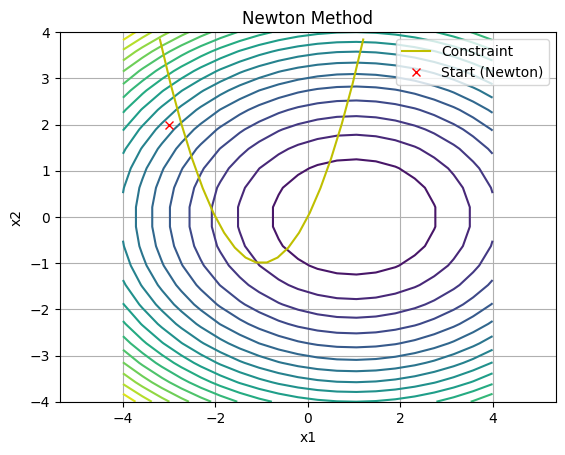

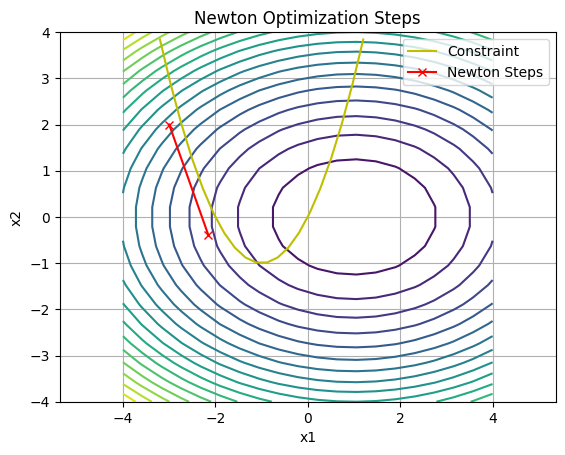

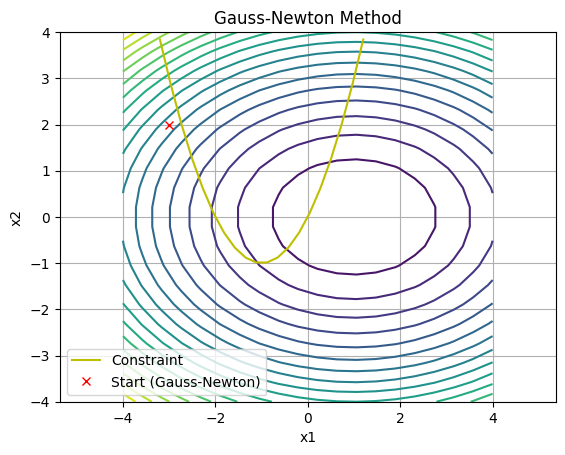

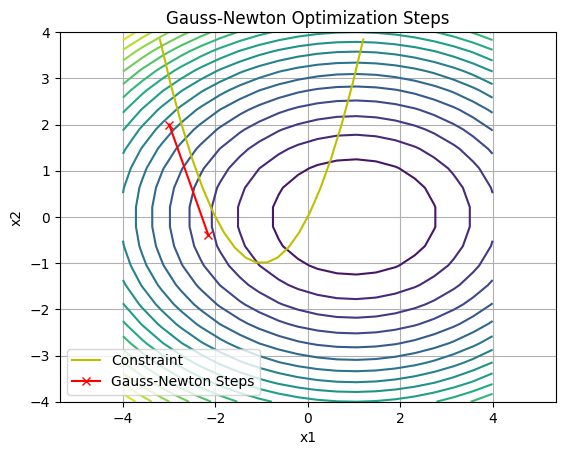

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

# ----------------------------
# Quadratic Objective
# ----------------------------
Q = np.diag([0.5, 1.0])

def f(x):
    x = np.array(x)
    return 0.5 * (x - np.array([1.0, 0])).T @ Q @ (x - np.array([1.0, 0]))

def grad_f(x):
    return Q @ (x - np.array([1.0, 0]))

def hess_f(x):
    return Q


# ----------------------------
# Nonlinear Constraint
# ----------------------------
def c(x):
    return x[0]**2 + 2*x[0] - x[1]

def dc(x):
    return np.array([[2*x[0] + 2, -1]])


# ----------------------------
# Plot Function Landscape
# ----------------------------
def plot_landscape():
    Nsamp = 20
    xgrid = np.linspace(-4, 4, Nsamp)
    ygrid = np.linspace(-4, 4, Nsamp)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.zeros_like(X)
    for i in range(Nsamp):
        for j in range(Nsamp):
            Z[i, j] = f([X[i, j], Y[i, j]])
    plt.contour(X, Y, Z, levels=20)

    xc = np.linspace(-3.2, 1.2, Nsamp)
    yc = xc**2 + 2 * xc
    plt.plot(xc, yc, "y", label="Constraint")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.axis("equal")


# ----------------------------
# Newton Step (Full)
# ----------------------------
def newton_step(x0, lam0):
    H = hess_f(x0) + np.sum([
        np.gradient(dc(x0)[0]) * lam0 # This part might also need review depending on the intended behavior
    ], axis=0)  # Just to match Julia behavior
    C = dc(x0)
    KKT = np.block([
        [H, C.T],
        [C, np.zeros((1, 1))]
    ])
    # Convert scalar lam0 to a 1D array for matrix multiplication
    lam0_vector = np.array([lam0])
    rhs = np.concatenate([-grad_f(x0) - C.T @ lam0_vector, [-c(x0)]])
    dz = solve(KKT, rhs)
    # dlam will be a 0D array (scalar) when sliced from dz
    dx, dlam = dz[:2], dz[2]
    return x0 + dx, float(dlam) # Convert dlam back to a float for consistency with lamguess list


# ----------------------------
# Gauss-Newton Step (Approximate Hessian)
# ----------------------------
def gauss_newton_step(x0, lam0):
    H = hess_f(x0)
    C = dc(x0)
    KKT = np.block([
        [H, C.T],
        [C, np.zeros((1, 1))]
    ])
    # Convert scalar lam0 to a 1D array for matrix multiplication
    lam0_vector = np.array([lam0])
    rhs = np.concatenate([-grad_f(x0) - C.T @ lam0_vector, [-c(x0)]])
    dz = solve(KKT, rhs)
    # dlam will be a 0D array (scalar) when sliced from dz
    dx, dlam = dz[:2], dz[2]
    return x0 + dx, float(dlam) # Convert dlam back to a float for consistency with lamguess list


# ----------------------------
# Run Newton Iteration
# ----------------------------
xguess = [np.array([-3.0, 2.0])]
lamguess = [0.0]

plot_landscape()
plt.plot(xguess[-1][0], xguess[-1][1], "rx", label="Start (Newton)")
plt.title("Newton Method")
plt.legend()
plt.show()

# Perform 1 Newton step
xnew, lamnew = newton_step(xguess[-1], lamguess[-1])
xguess.append(xnew)
lamguess.append(lamnew)

plot_landscape()
x_coords = [x[0] for x in xguess]
y_coords = [x[1] for x in xguess]
plt.plot(x_coords, y_coords, "rx-", label="Newton Steps")
plt.title("Newton Optimization Steps")
plt.legend()
plt.show()

# ----------------------------
# Run Gauss-Newton Iteration
# ----------------------------
xguess = [np.array([-3.0, 2.0])]
lamguess = [0.0]

plot_landscape()
plt.plot(xguess[-1][0], xguess[-1][1], "rx", label="Start (Gauss-Newton)")
plt.title("Gauss-Newton Method")
plt.legend()
plt.show()

# Perform 1 Gauss-Newton step
xnew, lamnew = gauss_newton_step(xguess[-1], lamguess[-1])
xguess.append(xnew)
lamguess.append(lamnew)

plot_landscape()
x_coords = [x[0] for x in xguess]
y_coords = [x[1] for x in xguess]
plt.plot(x_coords, y_coords, "rx-", label="Gauss-Newton Steps")
plt.title("Gauss-Newton Optimization Steps")
plt.legend()
plt.show()

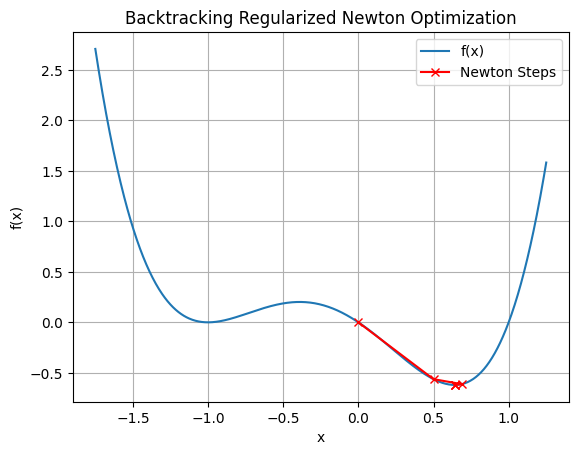

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Define f, grad f, hess f
# ------------------------
def f(x):
    return x**4 + x**3 - x**2 - x

def grad_f(x):
    return 4*x**3 + 3*x**2 - 2*x - 1

def hess_f(x):
    return 12*x**2 + 6*x - 2

# ------------------------
# Newton Step
# ------------------------
def newton_step(x0):
    H = hess_f(x0)
    g = grad_f(x0)
    return x0 - g / H

# ------------------------
# Regularized Newton Step
# ------------------------
def regularized_newton_step(x0):
    β = 1.0
    H = hess_f(x0)
    while H <= 0:  # scalar Hessian check
        H += β
    return x0 - grad_f(x0) / H

# ------------------------
# Regularized Newton + Backtracking
# ------------------------
def backtracking_regularized_newton_step(x0, b=0.1, c=0.5):
    β = 1.0
    H = hess_f(x0)
    while H <= 0:
        H += β
    Δx = -grad_f(x0) / H
    α = 1.0
    while f(x0 + α*Δx) > f(x0) + b * α * grad_f(x0) * Δx:
        α *= c
    return x0 + α * Δx

# ------------------------
# Plotting
# ------------------------
x = np.linspace(-1.75, 1.25, 1000)
y = f(x)
plt.plot(x, y, label="f(x)")

# ------------------------
# Run Newton Methods
# ------------------------

xguess = [0.0]  # Starting point

# Try regularized Newton + backtracking
for _ in range(5):  # Run a few steps
    xnew = backtracking_regularized_newton_step(xguess[-1])
    xguess.append(xnew)

# Plot guesses
plt.plot(xguess, f(np.array(xguess)), "rx-", label="Newton Steps")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Backtracking Regularized Newton Optimization")
plt.legend()
plt.grid(True)
plt.show()
